# Deep Learning with PyTorch : Build a Generative Adversarial Network 

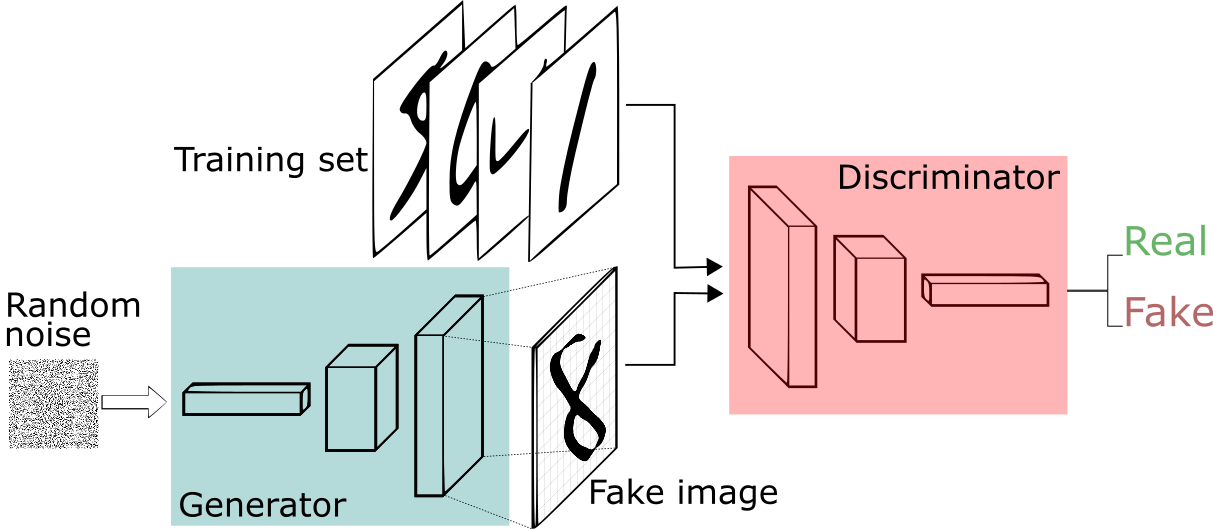

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64
# optimizer parameters
lr = .0002
beta_1 = .5
beta_2 = .99
#training variables
epochs = 20


# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_aug = T.Compose([
                       T.RandomRotation((-20, 20)),
                       T.ToTensor(),# (h, w, c) -> (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/', download = True, train= True, transform= train_aug)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



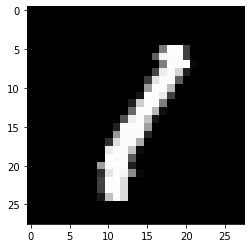

In [11]:
image, label = trainset[3]
plt.imshow(image.squeeze(), cmap = 'gray');

In [12]:
print('Total images in train set is: {}'.format(len(trainset)))

Total images in train set is: 60000


# Load Dataset Into Batches 

In [13]:
from torch.utils.data import  DataLoader
from torchvision.utils import make_grid

In [14]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle= True)

In [17]:
print('Total number of batches: {}'.format(len(trainloader)))

Total number of batches: 469


In [20]:
dataiter = iter(trainloader)
images, _ = dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [19]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

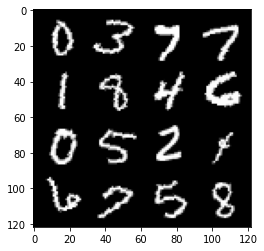

In [21]:
show_tensor_images(images)

# Create Discriminator Network 

In [22]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [24]:
def get_desc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                        nn.BatchNorm2d(out_channels),
                        nn.LeakyReLU(.2)
  )

In [25]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_desc_block(1, 16, (3,3), 2)
    self.block_2 = get_desc_block(16, 32, (5, 5), 2)
    self.block_3 = get_desc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features= 64, out_features= 1)


  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5





In [28]:
D = Discriminator()
D.to(device)
summary(D, input_size= (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [29]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()

  )

In [30]:
class Generator(nn.Module):

  def __init__ (self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4, 4), 1)
    self.block_3 = get_gen_block(128, 64, (3, 3), 2)
    self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block= True)

  def forward(self, r_noise_vec):
    # (bs, noise_dim) => (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4



In [31]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 747,843
Trainable params: 747,843
Non-trainable params: 0
-------------------------------

In [32]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [33]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [34]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss
  

In [39]:
D.opt = torch.optim.Adam(D.parameters(), lr = lr, betas= (beta_1, beta_2))
G.opt = torch.optim.Adam(G.parameters(), lr = lr, betas= (beta_1, beta_2))

# Training Loop 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 | G_loss: 0.7221952650084424 | D_loss: 0.6673392414538337 


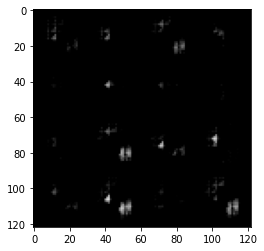

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 | G_loss: 0.7827724468733456 | D_loss: 0.6011320803719543 


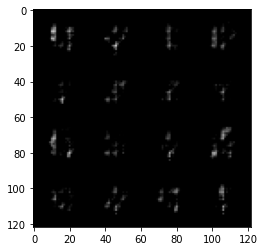

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3 | G_loss: 0.8675786779125108 | D_loss: 0.5557906220970886 


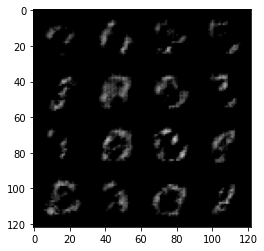

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4 | G_loss: 0.963326549987549 | D_loss: 0.4827647549765451 


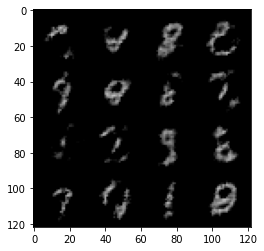

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5 | G_loss: 0.9426027458232603 | D_loss: 0.5169150540823622 


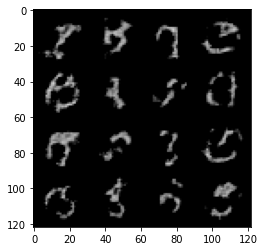

Epoch: 6 | G_loss: 0.7239206655701594 | D_loss: 0.673257088864536 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


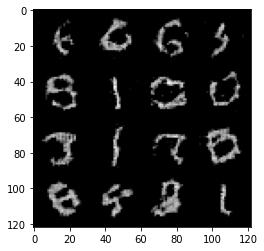

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7 | G_loss: 0.7400850654919264 | D_loss: 0.6689044460813119 


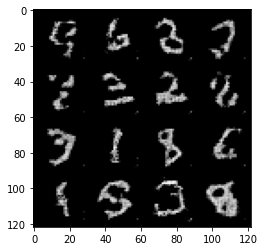

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8 | G_loss: 0.7460158349100207 | D_loss: 0.6659881111655408 


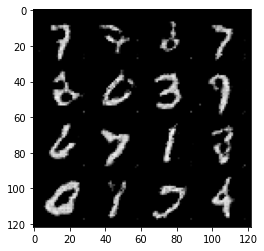

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9 | G_loss: 0.7583273857641322 | D_loss: 0.6616000988081828 


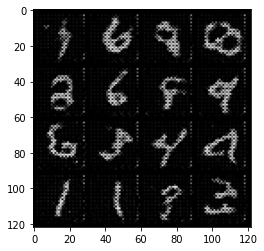

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 | G_loss: 0.7559285465079838 | D_loss: 0.6629825666515049 


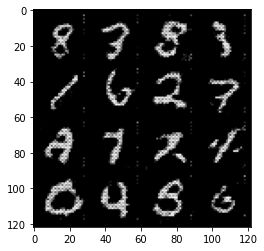

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11 | G_loss: 0.7436359717901836 | D_loss: 0.6735797068203436 


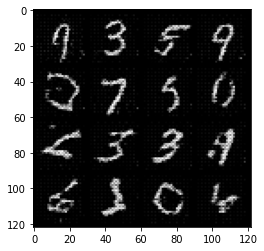

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12 | G_loss: 0.7424460621530822 | D_loss: 0.6742174752485524 


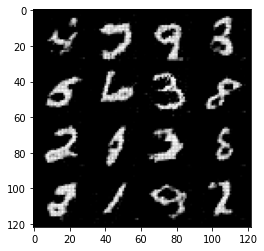

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 13 | G_loss: 0.7379339188655049 | D_loss: 0.6775532090333479 


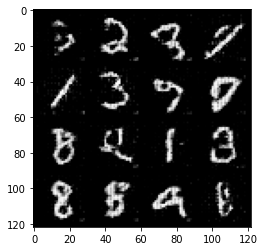

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 14 | G_loss: 0.7277467531690212 | D_loss: 0.6835796869894081 


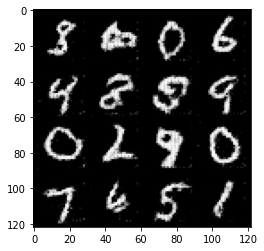

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15 | G_loss: 0.7225721146760464 | D_loss: 0.6874141272451324 


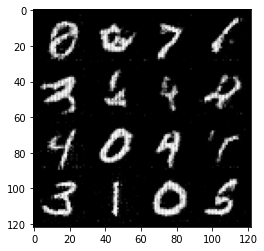

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 16 | G_loss: 0.7185293038262487 | D_loss: 0.6888303796111394 


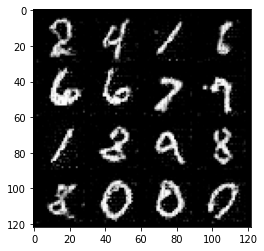

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 17 | G_loss: 0.7162897746954391 | D_loss: 0.689236734975884 


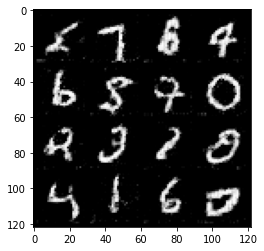

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 18 | G_loss: 0.712653739747208 | D_loss: 0.6901811070279527 


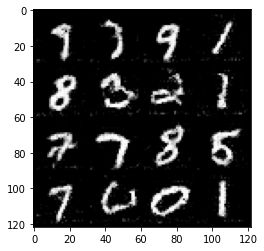

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 19 | G_loss: 0.7124369845969845 | D_loss: 0.690553385057429 


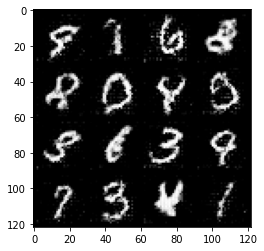

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20 | G_loss: 0.7113030222433208 | D_loss: 0.6904160677751244 


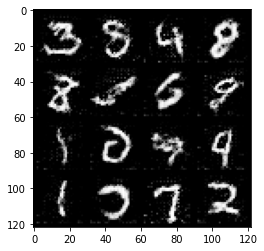

In [42]:
for i in range(epochs):
  total_d_loss = 0
  total_g_loss = 0

  for real_img, _ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)


  # for D
    D.opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss =( D_fake_loss + D_real_loss) / 2

    total_d_loss += D_loss.item()

    D_loss.backward()

    D.opt.step()

  # for G
    G.opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()


    G_loss.backward()
    G.opt.step()
  
  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | G_loss: {} | D_loss: {} ".format(i+1, avg_g_loss, avg_d_loss))
  show_tensor_images(fake_img)








Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


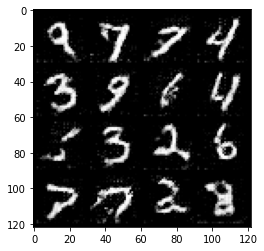

In [43]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)